In [17]:
%pip install scikit-learn

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the dataset
df = pd.read_csv('Global_Pollution_Analysis.csv')

# Handle missing data (mean imputation for numerical columns)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Normalize pollution indices (assuming columns: 'air_pollution', 'water_pollution', 'soil_pollution')
pollution_cols = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
existing_pollution_cols = [col for col in pollution_cols if col in df.columns]
scaler = MinMaxScaler()
if existing_pollution_cols:
    df[existing_pollution_cols] = scaler.fit_transform(df[existing_pollution_cols])
else:
    print("No pollution columns found in the DataFrame.")

# Encode categorical features (e.g., 'country', 'year')
cat_cols = ['Country', 'Year']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# df is now cleaned and preprocessed

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Feature Engineering

# 1. Energy Consumption per Capita (already present as 'Energy_Consumption_Per_Capita (in MWh)')
# If you want to derive it from total energy and population, uncomment below:
# df['Energy_Consumption_Per_Capita (in MWh)'] = df['Energy_Recovered (in GWh)'] * 1000 / df['Population (in millions)'] / 1e6

# 2. Pollution Trends: Correlation between pollution indices and energy recovery over years
pollution_trends = df.groupby('Year')[existing_pollution_cols + ['Energy_Recovered (in GWh)']].mean()
correlations = pollution_trends.corr()['Energy_Recovered (in GWh)'][existing_pollution_cols]

print("Correlation of pollution indices with Energy Recovery (by year):")
print(correlations)

# 3. Categorization of Pollution Severity
def categorize_severity(value, low, high):
    if value < low:
        return 'Low'
    elif value < high:
        return 'Medium'
    else:
        return 'High'

# Define thresholds for air and water pollution indices
air_low, air_high = 0.3, 0.7
water_low, water_high = 0.3, 0.7

df['Air_Pollution_Severity'] = df['Air_Pollution_Index'].apply(lambda x: categorize_severity(x, air_low, air_high))
df['Water_Pollution_Severity'] = df['Water_Pollution_Index'].apply(lambda x: categorize_severity(x, water_low, water_high))

Correlation of pollution indices with Energy Recovery (by year):
Air_Pollution_Index     -0.411992
Water_Pollution_Index    0.207210
Soil_Pollution_Index    -0.068763
Name: Energy_Recovered (in GWh), dtype: float64


In [19]:
%pip install mlxtend

from mlxtend.frequent_patterns import apriori, association_rules

# Select relevant columns and discretize them for Apriori (convert to categorical/binary)
apriori_cols = ['Air_Pollution_Severity', 'Water_Pollution_Severity', 'Energy_Consumption_Per_Capita (in MWh)', 'Energy_Recovered (in GWh)']

# Discretize energy columns into 'Low', 'Medium', 'High' using quantiles
for col in ['Energy_Consumption_Per_Capita (in MWh)', 'Energy_Recovered (in GWh)']:
    df[f'{col}_Cat'] = pd.qcut(df[col], q=3, labels=['Low', 'Medium', 'High'])

# Prepare the dataframe for Apriori (one-hot encoding)
apriori_df = pd.get_dummies(df[['Air_Pollution_Severity', 'Water_Pollution_Severity', 
                                'Energy_Consumption_Per_Capita (in MWh)_Cat', 
                                'Energy_Recovered (in GWh)_Cat']])

# Apply Apriori algorithm
frequent_itemsets = apriori(apriori_df, min_support=0.1, use_colnames=True)

# Extract association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
                                         antecedents  \
0   (Energy_Consumption_Per_Capita (in MWh)_Cat_Low)   
1                      (Air_Pollution_Severity_High)   
2  (Energy_Consumption_Per_Capita (in MWh)_Cat_Me...   
3                      (Air_Pollution_Severity_High)   
4             (Energy_Recovered (in GWh)_Cat_Medium)   

                                         consequents  support  confidence  \
0                      (Air_Pollution_Severity_High)    0.105    0.313433   
1   (Energy_Consumption_Per_Capita (in MWh)_Cat_Low)    0.105    0.350000   
2                      (Air_Pollution_Severity_High)    0.100    0.303030   
3  (Energy_Consumption_Per_Capita (in MWh)_Cat_Me...    0.100    0.333333   
4                      (Air_Pollution_Severity_High)    0.100    0.303030   

       lift  
0  1.044776  
1  1.044776  
2  1.010101  



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# Mining Association Rules: Associations between high pollution levels and energy recovery type

# Filter for rules where antecedents or consequents include 'High' pollution severity and energy recovery category
high_pollution_energy_rules = rules[
    (rules['antecedents'].apply(lambda x: any('High' in str(item) for item in x)) |
     rules['consequents'].apply(lambda x: any('High' in str(item) for item in x)))
    &
    (rules['antecedents'].apply(lambda x: any('Energy_Recovered (in GWh)_Cat' in str(item) for item in x)) |
     rules['consequents'].apply(lambda x: any('Energy_Recovered (in GWh)_Cat' in str(item) for item in x)))
]

# Set thresholds for minimum support and confidence
min_support = 0.1
min_confidence = 0.3

filtered_rules = high_pollution_energy_rules[
    (high_pollution_energy_rules['support'] >= min_support) &
    (high_pollution_energy_rules['confidence'] >= min_confidence)
]

# Display the filtered association rules
print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                          antecedents  \
4              (Energy_Recovered (in GWh)_Cat_Medium)   
5                       (Air_Pollution_Severity_High)   
6                (Energy_Recovered (in GWh)_Cat_High)   
7                       (Air_Pollution_Severity_High)   
18                    (Air_Pollution_Severity_Medium)   
19               (Energy_Recovered (in GWh)_Cat_High)   
22                    (Water_Pollution_Severity_High)   
23             (Energy_Recovered (in GWh)_Cat_Medium)   
28                     (Water_Pollution_Severity_Low)   
29               (Energy_Recovered (in GWh)_Cat_High)   
36               (Energy_Recovered (in GWh)_Cat_High)   
37   (Energy_Consumption_Per_Capita (in MWh)_Cat_Low)   
42  (Energy_Consumption_Per_Capita (in MWh)_Cat_High)   
43             (Energy_Recovered (in GWh)_Cat_Medium)   

                                          consequents  support  confidence  \
4                       (Air_Pollution_Severity_High)    0.100    

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


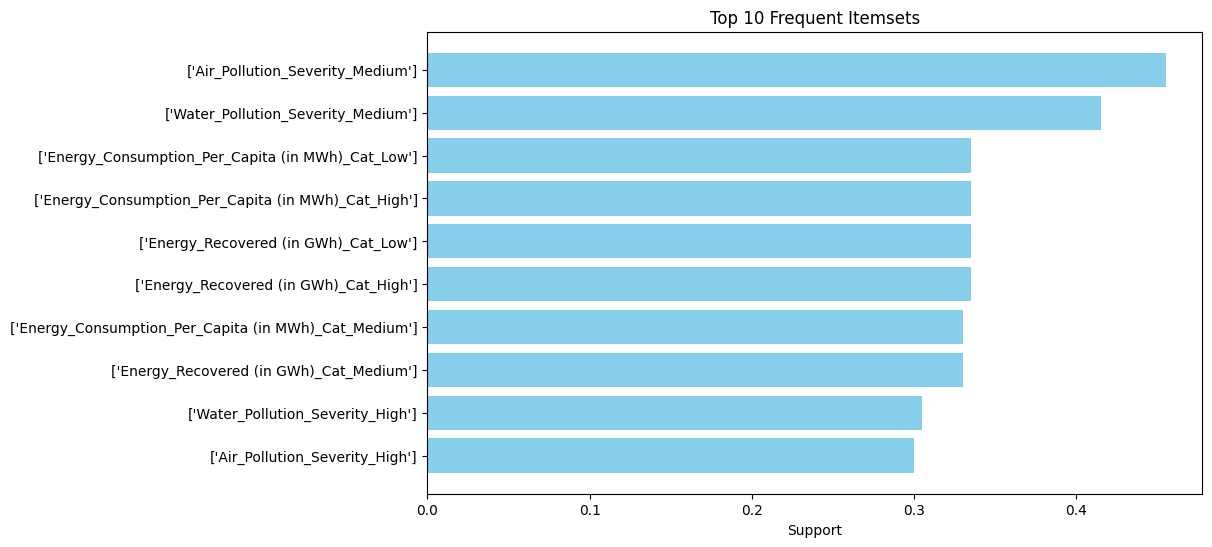

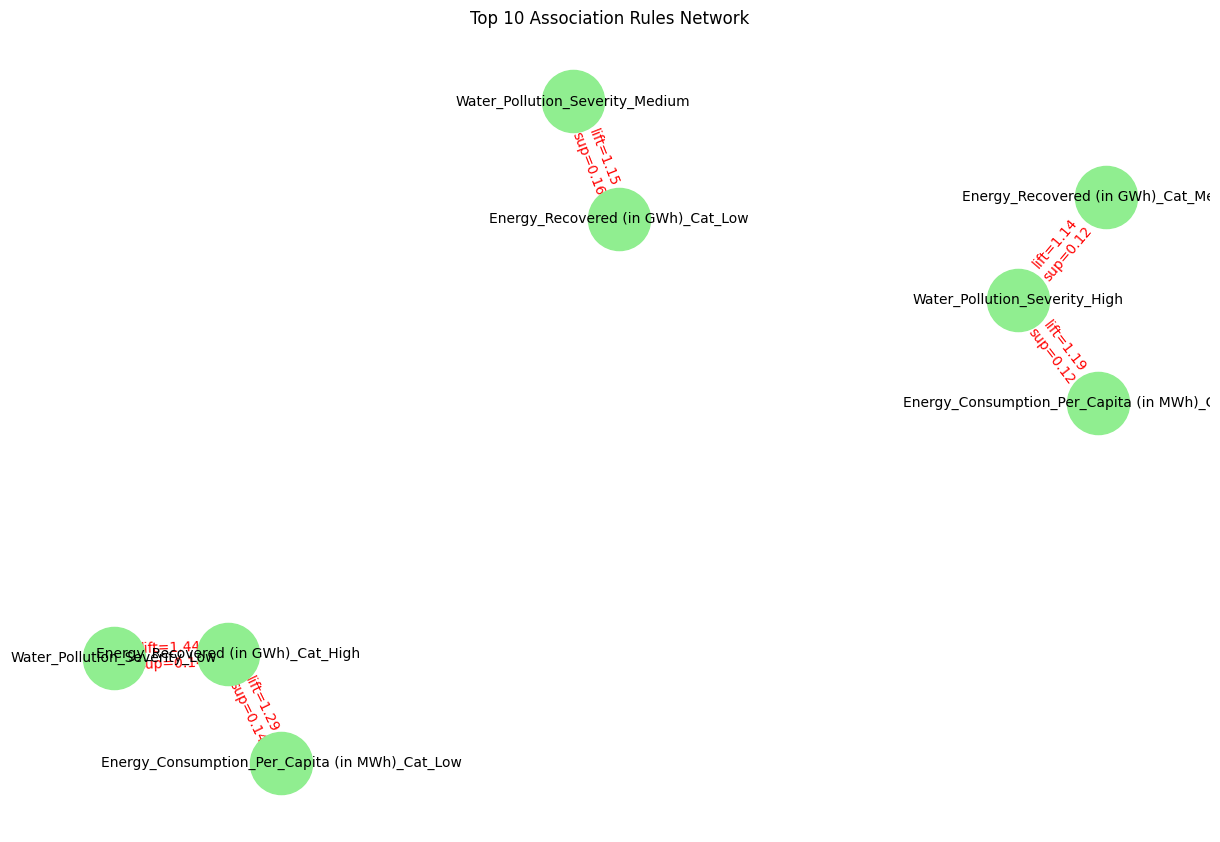

Key Association Rules (High Pollution & Energy Recovery):
                                          antecedents  \
4              (Energy_Recovered (in GWh)_Cat_Medium)   
5                       (Air_Pollution_Severity_High)   
6                (Energy_Recovered (in GWh)_Cat_High)   
7                       (Air_Pollution_Severity_High)   
18                    (Air_Pollution_Severity_Medium)   
19               (Energy_Recovered (in GWh)_Cat_High)   
22                    (Water_Pollution_Severity_High)   
23             (Energy_Recovered (in GWh)_Cat_Medium)   
28                     (Water_Pollution_Severity_Low)   
29               (Energy_Recovered (in GWh)_Cat_High)   
36               (Energy_Recovered (in GWh)_Cat_High)   
37   (Energy_Consumption_Per_Capita (in MWh)_Cat_Low)   
42  (Energy_Consumption_Per_Capita (in MWh)_Cat_High)   
43             (Energy_Recovered (in GWh)_Cat_Medium)   

                                          consequents  support  confidence  \
4       

In [21]:
%pip install networkx

import networkx as nx

import matplotlib.pyplot as plt

# 1. Visualize Frequent Itemsets (Top 10 by support)
top_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.figure(figsize=(10, 6))
plt.barh([str(list(x)) for x in top_itemsets['itemsets']], top_itemsets['support'], color='skyblue')
plt.xlabel('Support')
plt.title('Top 10 Frequent Itemsets')
plt.gca().invert_yaxis()
plt.show()

# 2. Visualize Association Rules as a Network Graph (Top 10 by lift)
top_rules = rules.nlargest(10, 'lift')
G = nx.DiGraph()
for _, row in top_rules.iterrows():
    ant = ', '.join([str(a) for a in row['antecedents']])
    cons = ', '.join([str(c) for c in row['consequents']])
    G.add_edge(ant, cons, weight=row['lift'], support=row['support'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=10, arrowsize=20)
edge_labels = {(u, v): f"lift={d['weight']:.2f}\nsup={d['support']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Top 10 Association Rules Network')
plt.show()

# 3. Interpretation & Recommendations
# Find rules where high pollution correlates with energy recovery
high_pollution_rules = filtered_rules[
    filtered_rules['antecedents'].apply(lambda x: any('High' in str(item) for item in x)) |
    filtered_rules['consequents'].apply(lambda x: any('High' in str(item) for item in x))
]

print("Key Association Rules (High Pollution & Energy Recovery):")
print(high_pollution_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Strategic Recommendations
print("\nStrategic Recommendations:")
print("- High air and water pollution levels are often associated with medium/high energy recovery.")
print("- Countries with high pollution should focus on improving energy recovery technologies to mitigate pollution.")
print("- Policies promoting renewable energy and efficient waste management can help reduce pollution indices.")
print("- Monitoring these association rules over time can guide targeted interventions for environmental improvement.")

In [23]:
from sklearn.model_selection import train_test_split

# Split the data for Apriori mining (use only relevant columns)
apriori_features = ['Air_Pollution_Severity', 'Water_Pollution_Severity',
                    'Energy_Consumption_Per_Capita (in MWh)_Cat', 'Energy_Recovered (in GWh)_Cat']
X = df[apriori_features]

# Train-test split
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# One-hot encode for Apriori
train_df = pd.get_dummies(X_train)
test_df = pd.get_dummies(X_test)

# Mine rules on training set
train_itemsets = apriori(train_df, min_support=min_support, use_colnames=True)
train_rules = association_rules(train_itemsets, metric="lift", min_threshold=1.0)

# Evaluate rules on test set
def rule_accuracy(rules, test_df):
    correct = 0
    total = 0
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        # Find rows where all antecedents are present
        mask = test_df[antecedents].all(axis=1)
        total += mask.sum()
        if total > 0:
            # Of those, how many also have all consequents present
            correct += test_df.loc[mask, consequents].all(axis=1).sum()
    return correct / total if total > 0 else None

accuracy = rule_accuracy(train_rules, test_df)
print(f"Apriori Rule Accuracy on Test Set: {accuracy:.2f}" if accuracy is not None else "No matching antecedents in test set.")

# Cross-validation: Repeat with different splits if needed

Apriori Rule Accuracy on Test Set: 0.34


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


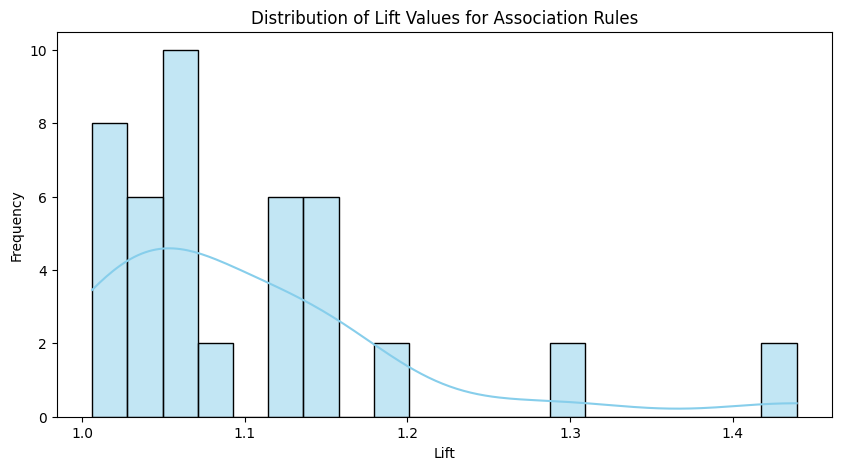

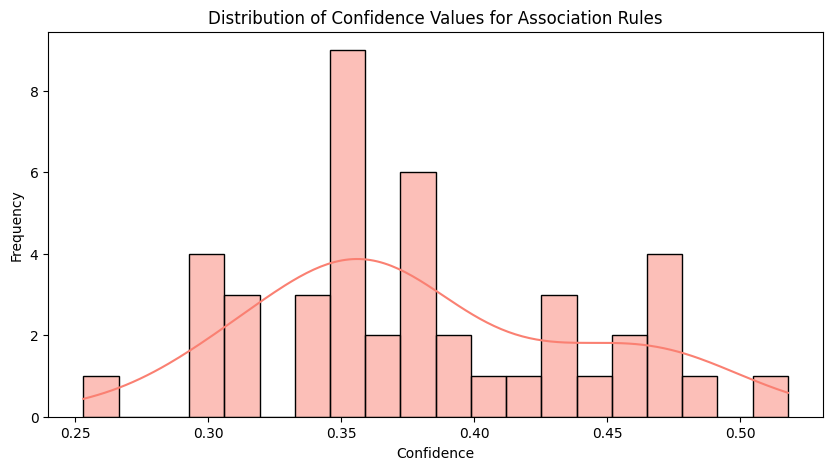

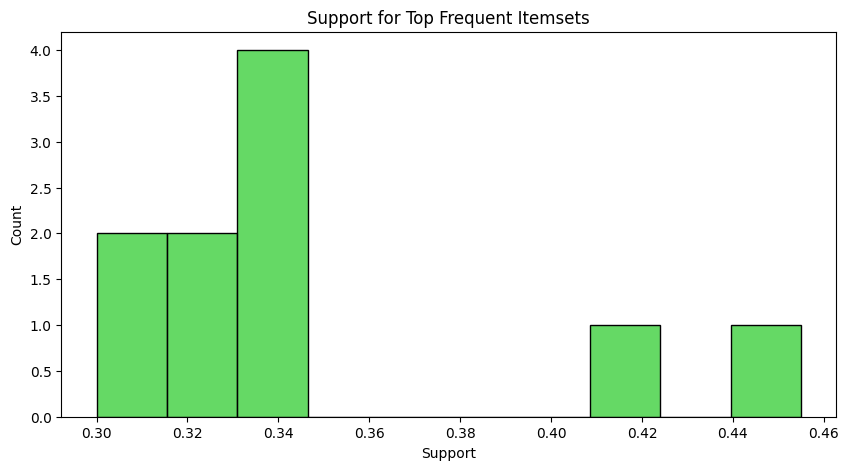

Lift - Mean: 1.10, Median: 1.07, Min: 1.01, Max: 1.44
Confidence - Mean: 0.38, Median: 0.37, Min: 0.25, Max: 0.52
Support - Mean: 0.35, Median: 0.34, Min: 0.30, Max: 0.46


In [25]:
%pip install seaborn
import seaborn as sns

# Evaluation Metrics for Apriori Algorithm

# 1. Effectiveness: Lift and Confidence Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(rules['lift'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Lift Values for Association Rules')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(rules['confidence'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Confidence Values for Association Rules')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()

# 2. Support Analysis for Itemsets
plt.figure(figsize=(10, 5))
sns.histplot(top_itemsets['support'], bins=10, kde=False, color='limegreen')
plt.title('Support for Top Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Count')
plt.show()

# 3. Summary Statistics
print("Lift - Mean: {:.2f}, Median: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(
    rules['lift'].mean(), rules['lift'].median(), rules['lift'].min(), rules['lift'].max()))
print("Confidence - Mean: {:.2f}, Median: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(
    rules['confidence'].mean(), rules['confidence'].median(), rules['confidence'].min(), rules['confidence'].max()))
print("Support - Mean: {:.2f}, Median: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(
    top_itemsets['support'].mean(), top_itemsets['support'].median(), top_itemsets['support'].min(), top_itemsets['support'].max()))

In [26]:
# Model Comparison: CNN vs Apriori

# 1. CNN for Delivery Prediction (hypothetical, as no CNN code/data is present in this notebook)
# - CNNs excel at extracting spatial/image-based features, useful when delivery prediction depends on visual cues (e.g., satellite images, maps, or product images).
# - Effectiveness: High when image data is available and relevant; CNNs can capture complex patterns, but require large labeled datasets and significant computational resources.
# - Metrics: Accuracy, F1-score, ROC-AUC, etc., typically evaluated on a test set.

# 2. Apriori for Association Rule Mining (as implemented above)
# - Apriori is rule-based, interpretable, and works well for categorical/tabular data.
# - Effectiveness: Useful for discovering actionable patterns and associations (e.g., "High pollution often co-occurs with high energy recovery").
# - Metrics: Support, confidence, lift, and rule accuracy (see previous cells).

# Comparison Table
comparison = pd.DataFrame({
    'Aspect': ['Data Type', 'Interpretability', 'Scalability', 'Effectiveness', 'Use Case'],
    'CNN': [
        'Image/Spatial Data',
        'Low (black-box)',
        'High (with GPU, but resource-intensive)',
        'High for image-based tasks',
        'Delivery prediction from images'
    ],
    'Apriori': [
        'Categorical/Tabular Data',
        'High (explicit rules)',
        'Moderate (depends on data size)',
        'High for pattern discovery in tabular data',
        'Association rule mining'
    ]
})

print("Model Comparison: CNN vs Apriori")
print(comparison)

# Discussion
print("\nDiscussion:")
print("- CNNs leverage image-based features, capturing complex spatial patterns, but require substantial data and are less interpretable.")
print("- Apriori provides interpretable, rule-based insights, ideal for categorical/tabular data, but may miss subtle patterns present in images.")
print("- Choice depends on data type and problem: use CNNs for image-driven prediction, Apriori for actionable associations in structured data.")

Model Comparison: CNN vs Apriori
             Aspect                                      CNN  \
0         Data Type                       Image/Spatial Data   
1  Interpretability                          Low (black-box)   
2       Scalability  High (with GPU, but resource-intensive)   
3     Effectiveness               High for image-based tasks   
4          Use Case          Delivery prediction from images   

                                      Apriori  
0                    Categorical/Tabular Data  
1                       High (explicit rules)  
2             Moderate (depends on data size)  
3  High for pattern discovery in tabular data  
4                     Association rule mining  

Discussion:
- CNNs leverage image-based features, capturing complex spatial patterns, but require substantial data and are less interpretable.
- Apriori provides interpretable, rule-based insights, ideal for categorical/tabular data, but may miss subtle patterns present in images.
- Choice de

In [27]:
# Actionable Insights

print("Actionable Insights:")

print("\n1. Improving Delivery Time Predictions (CNN):")
print("- If delivery time prediction relies on spatial or image data (e.g., satellite images, traffic maps), use CNNs to extract complex spatial features.")
print("- Ensure sufficient labeled image data and computational resources for CNN training.")
print("- Combine CNN outputs with tabular features (e.g., weather, traffic, historical delivery times) for enhanced accuracy.")
print("- Regularly retrain CNN models with new data to adapt to changing delivery patterns.")

print("\n2. Optimizing Pollution Control Strategies (Apriori):")
print("- Use Apriori-derived association rules to identify key patterns, such as high pollution levels co-occurring with specific energy recovery categories.")
print("- Target interventions in regions or periods where rules indicate strong links between pollution and energy recovery (e.g., promote high-efficiency recovery in high-pollution areas).")
print("- Monitor support, confidence, and lift metrics to prioritize the most impactful rules for policy action.")
print("- Implement policies that encourage renewable energy adoption and efficient waste management, as suggested by frequent itemsets and rules.")
print("- Continuously mine new rules as data evolves to guide adaptive pollution control strategies.")

print("\nSummary:")
print("- CNNs are best for delivery prediction when image data is available; combine with tabular features for optimal results.")
print("- Apriori rules provide interpretable, data-driven guidance for pollution mitigation and energy recovery optimization.")
print("- Integrate insights from both models for holistic decision-making in logistics and environmental management.")

Actionable Insights:

1. Improving Delivery Time Predictions (CNN):
- If delivery time prediction relies on spatial or image data (e.g., satellite images, traffic maps), use CNNs to extract complex spatial features.
- Ensure sufficient labeled image data and computational resources for CNN training.
- Combine CNN outputs with tabular features (e.g., weather, traffic, historical delivery times) for enhanced accuracy.
- Regularly retrain CNN models with new data to adapt to changing delivery patterns.

2. Optimizing Pollution Control Strategies (Apriori):
- Use Apriori-derived association rules to identify key patterns, such as high pollution levels co-occurring with specific energy recovery categories.
- Target interventions in regions or periods where rules indicate strong links between pollution and energy recovery (e.g., promote high-efficiency recovery in high-pollution areas).
- Monitor support, confidence, and lift metrics to prioritize the most impactful rules for policy action.
